In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'USD'
share_name = 'PXT.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2014-03-31,155,-19,137,11,40,123,5,211,61,...,882,0,0,0,174,69,383,35,-61,136.14
1,2014-06-30,158,-25,133,12,63,110,9,244,61,...,1227,0,0,0,213,124,542,53,-122,136.14
2,2014-09-30,204,-41,163,17,34,181,14,281,61,...,1267,0,0,0,236,42,463,40,-30,136.14
3,2014-12-31,144,-39,105,-126,39,74,11,187,74,...,1034,0,0,0,183,35,374,121,-83,136.14
4,2015-03-31,124,-28,96,-15,33,68,8,172,74,...,1010,0,0,0,162,40,362,-4,-27,151.83


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2022-12-31,2023-02-11,113.66,312,-38,274,250,419,113,5,...,0,2314,0,0,1,509,0,599,298,-204
36,2023-03-31,2023-04-21,106.29,271,-43,228,104,372,89,2,...,0,2350,0,0,1,499,0,591,131,-134
37,2023-06-30,2023-07-21,106.29,274,-46,228,101,133,118,4,...,0,2226,0,0,1,325,0,420,-37,-142
38,2023-09-30,2023-10-21,106.29,315,-50,265,120,35,143,3,...,0,2264,0,0,1,298,0,390,87,-156
39,2023-12-31,2024-02-11,106.29,310,-72,238,134,140,106,4,...,0,2415,0,0,1,258,90,460,194,-91


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,113.66,312,-38,274,250,419,113,5,...,2314,0,0,1,509,0,599,298,-204,1.357405
36,2023-03-31,2023-04-21,106.29,271,-43,228,104,372,89,2,...,2350,0,0,1,499,0,591,131,-134,1.352063
37,2023-06-30,2023-07-21,106.29,274,-46,228,101,133,118,4,...,2226,0,0,1,325,0,420,-37,-142,1.343352
38,2023-09-30,2023-10-21,106.29,315,-50,265,120,35,143,3,...,2264,0,0,1,298,0,390,87,-156,1.341033
39,2023-12-31,2024-02-11,106.29,310,-72,238,134,140,106,4,...,2415,0,0,1,258,90,460,194,-91,1.361617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,113.66,423.510386,-51.581393,371.928993,339.351271,568.752731,153.386775,6.787025,...,3141.035366,0.0,0.0,1.357405,690.919188,0.000000,813.085646,404.506715,-276.910637,1.357405
36,2023-03-31,2023-04-21,106.29,366.408980,-58.138694,308.270285,140.614516,502.967308,120.333576,2.704125,...,3177.347241,0.0,0.0,1.352063,674.679265,0.000000,799.069029,177.120208,-181.176396,1.352063
37,2023-06-30,2023-07-21,106.29,368.078372,-61.794179,306.284193,135.678524,178.665779,158.515503,5.373407,...,2990.300937,0.0,0.0,1.343352,436.589310,0.000000,564.207724,-49.704014,-190.755945,1.343352
38,2023-09-30,2023-10-21,106.29,422.425371,-67.051646,355.373725,160.923951,46.936152,191.767708,4.023099,...,3036.098538,0.0,0.0,1.341033,399.627811,0.000000,523.002840,116.669864,-209.201136,1.341033
39,2023-12-31,2024-02-11,106.29,422.101391,-98.036452,324.064939,182.456730,190.626434,144.331443,5.446470,...,3288.305995,0.0,0.0,1.361617,351.297286,122.545565,626.343999,264.153773,-123.907182,1.361617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-04-21,9.436063,2014-03-31,170.74553,0.356028,4.037685,136.14,423.008281,3.107156,44.063363,...,0.56576,0.43424,5.04065,inf,15.5,15.2,0.883871,0.070968,0.049887,0.088176
1,2014-04-28,9.479506,2014-03-31,170.74553,0.356028,4.037685,136.14,423.008281,3.107156,44.063363,...,0.56576,0.43424,5.04065,inf,15.5,15.2,0.883871,0.070968,0.049887,0.088176
2,2014-05-05,9.575086,2014-03-31,170.74553,0.356028,4.037685,136.14,423.008281,3.107156,44.063363,...,0.56576,0.43424,5.04065,inf,15.5,15.2,0.883871,0.070968,0.049887,0.088176
3,2014-05-12,9.992147,2014-03-31,170.74553,0.356028,4.037685,136.14,423.008281,3.107156,44.063363,...,0.56576,0.43424,5.04065,inf,15.5,15.2,0.883871,0.070968,0.049887,0.088176
4,2014-05-19,10.244123,2014-03-31,170.74553,0.356028,4.037685,136.14,423.008281,3.107156,44.063363,...,0.56576,0.43424,5.04065,inf,15.5,15.2,0.883871,0.070968,0.049887,0.088176


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-04-21,9.436063,2014-03-31,170.74553,0.356028,4.037685,136.14,423.008281,3.107156,44.063363,...,15.2,0.883871,0.070968,0.049887,0.088176,26.503684,2.336998,1.880907,2.434132,3.036880
1,2014-04-28,9.479506,2014-03-31,170.74553,0.356028,4.037685,136.14,423.008281,3.107156,44.063363,...,15.2,0.883871,0.070968,0.049887,0.088176,26.625705,2.347758,1.889566,2.442792,3.050862
2,2014-05-05,9.575086,2014-03-31,170.74553,0.356028,4.037685,136.14,423.008281,3.107156,44.063363,...,15.2,0.883871,0.070968,0.049887,0.088176,26.894167,2.371430,1.908618,2.461844,3.081623
3,2014-05-12,9.992147,2014-03-31,170.74553,0.356028,4.037685,136.14,423.008281,3.107156,44.063363,...,15.2,0.883871,0.070968,0.049887,0.088176,28.065595,2.474722,1.991752,2.544978,3.215849
4,2014-05-19,10.244123,2014-03-31,170.74553,0.356028,4.037685,136.14,423.008281,3.107156,44.063363,...,15.2,0.883871,0.070968,0.049887,0.088176,28.773337,2.537128,2.041979,2.595205,3.296945


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

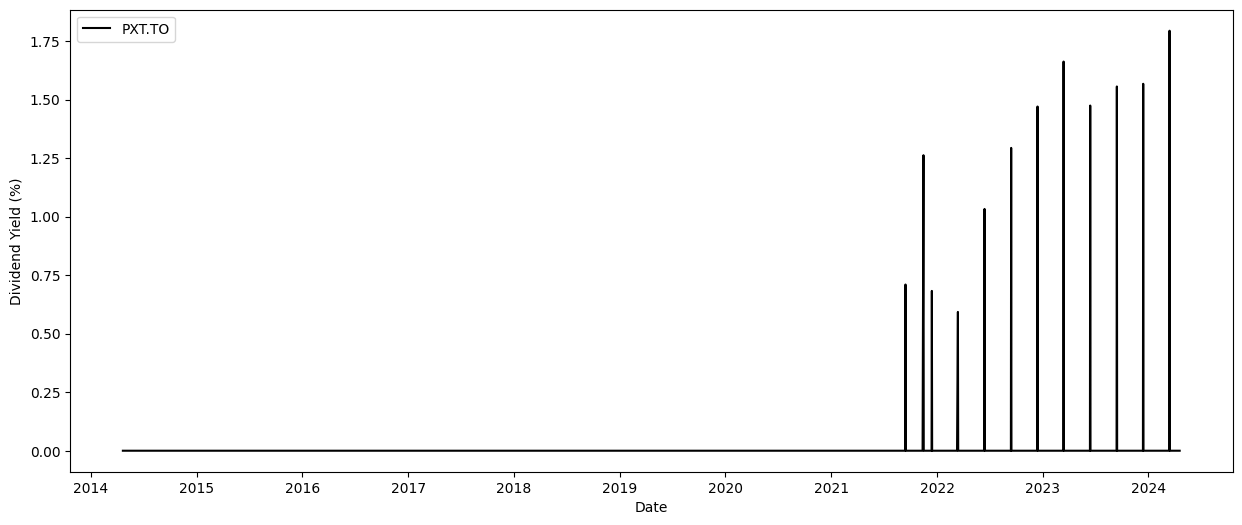

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.297566
share_price      1.000000
Name: share_price, dtype: float64


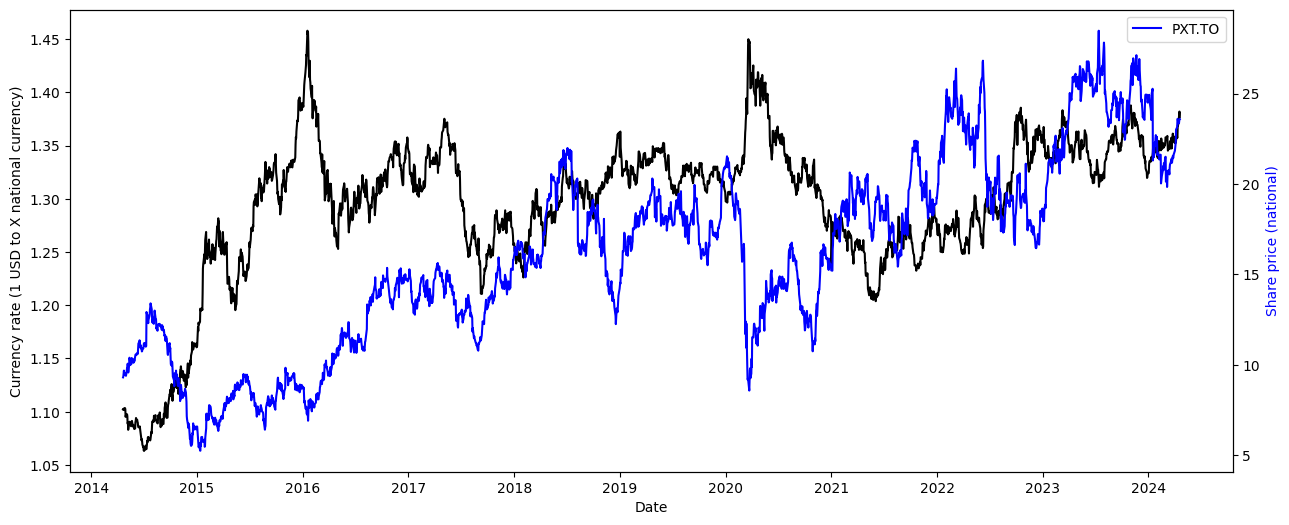

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

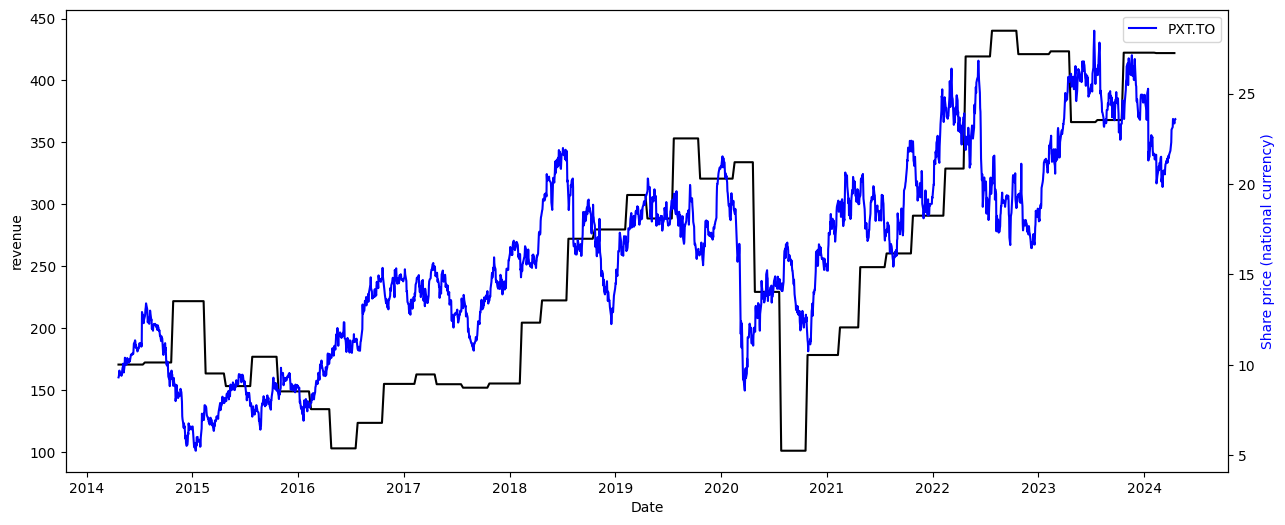

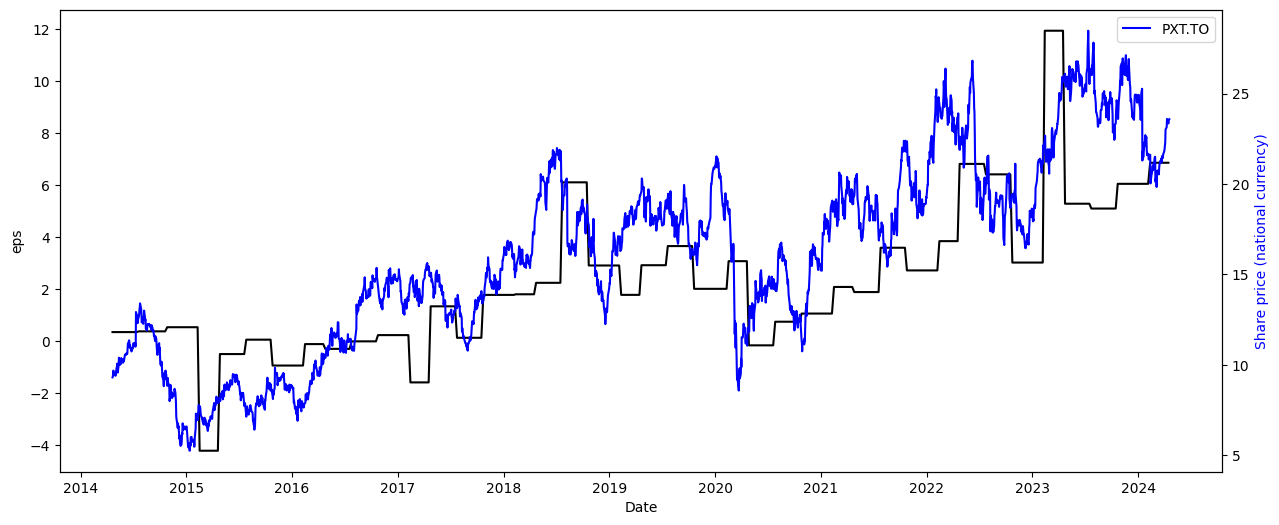

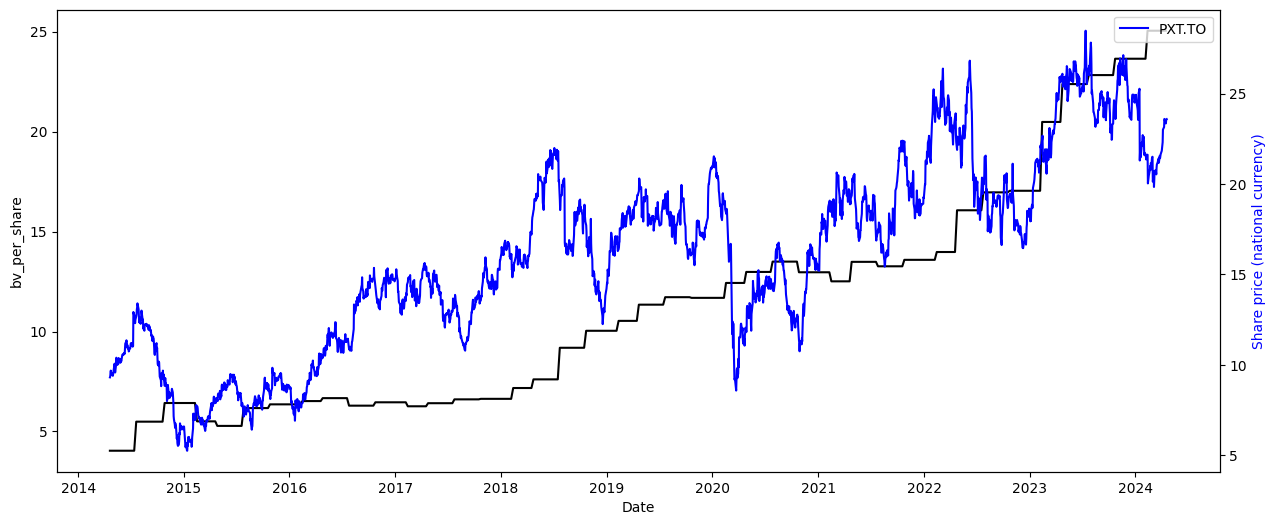

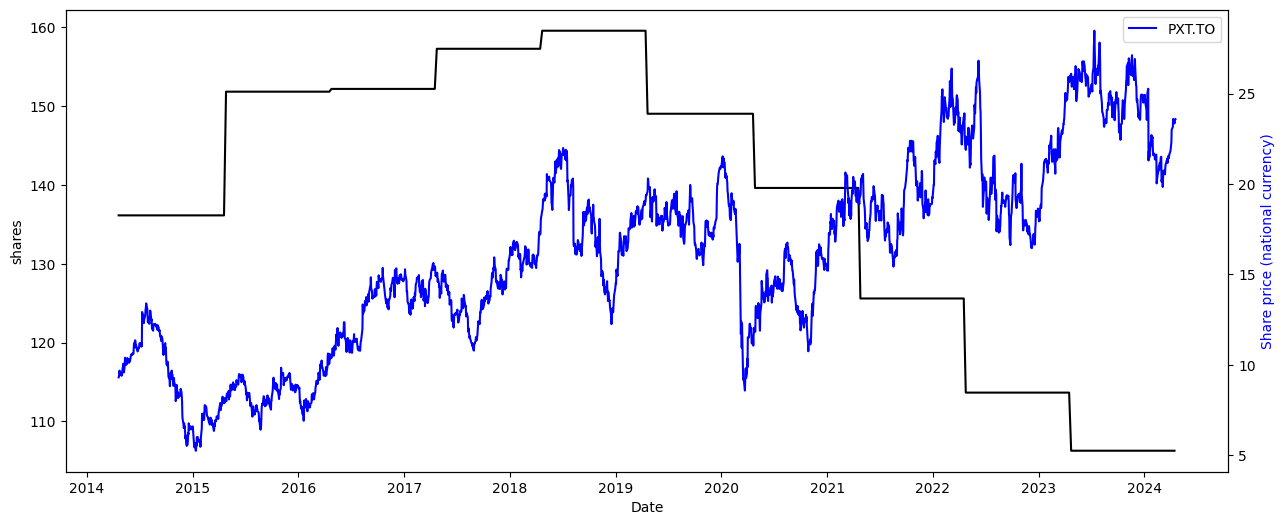

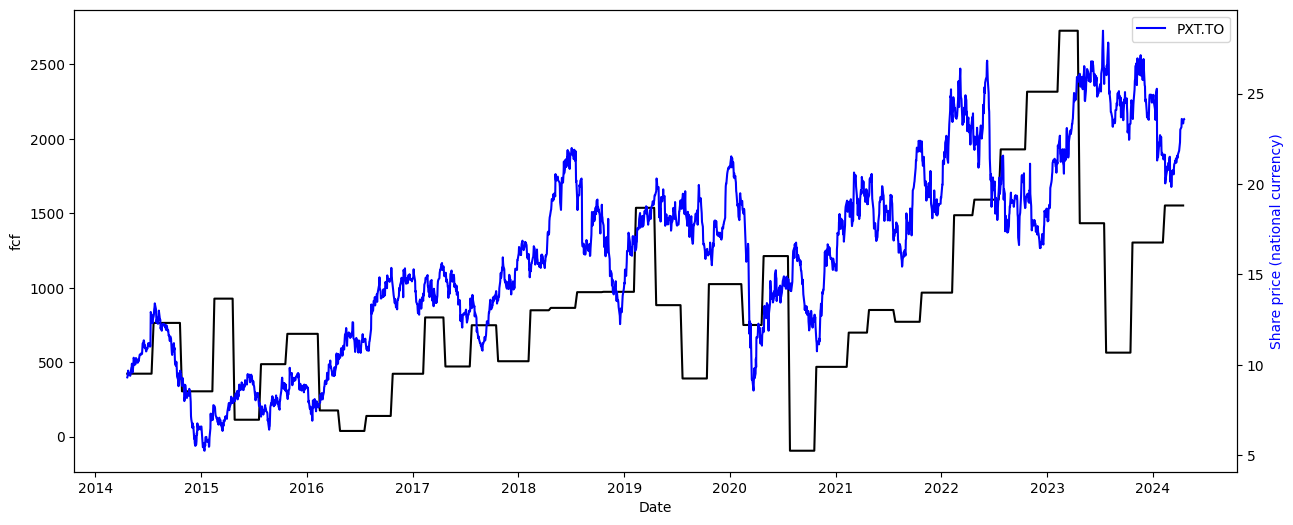

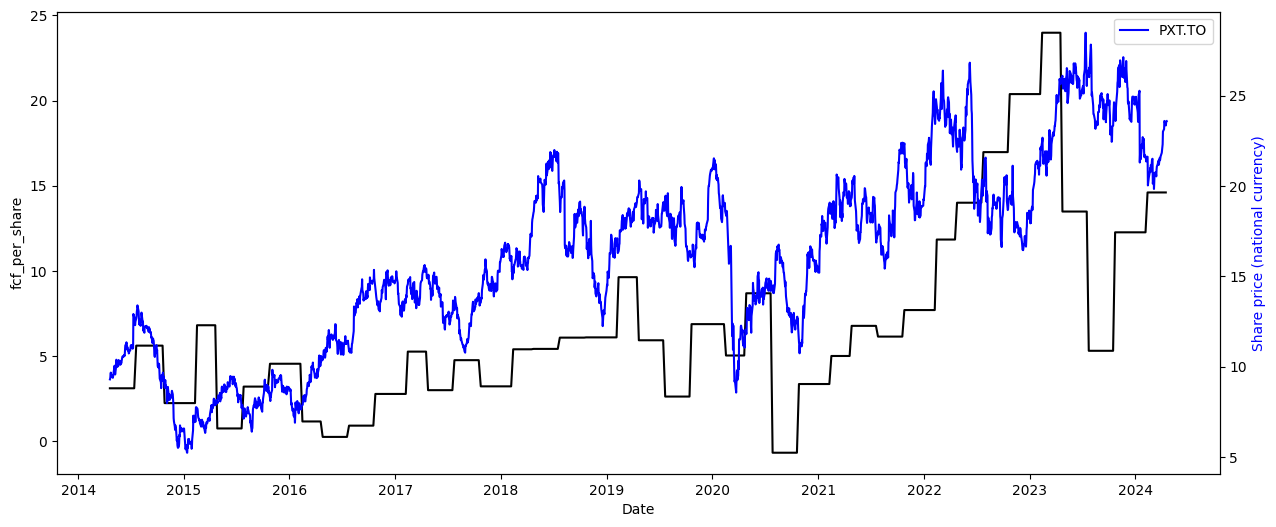

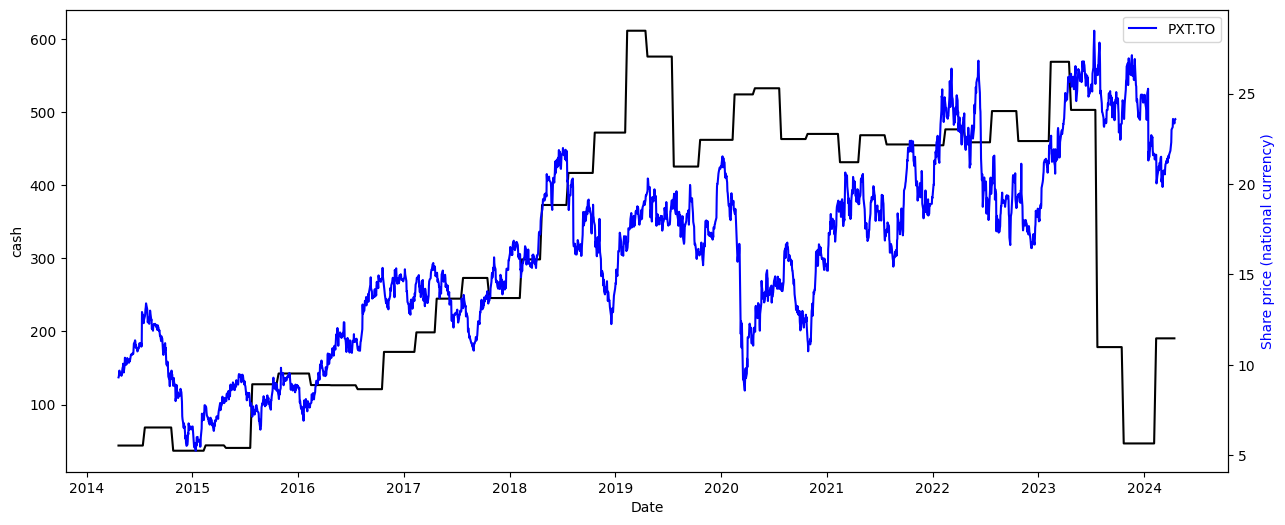

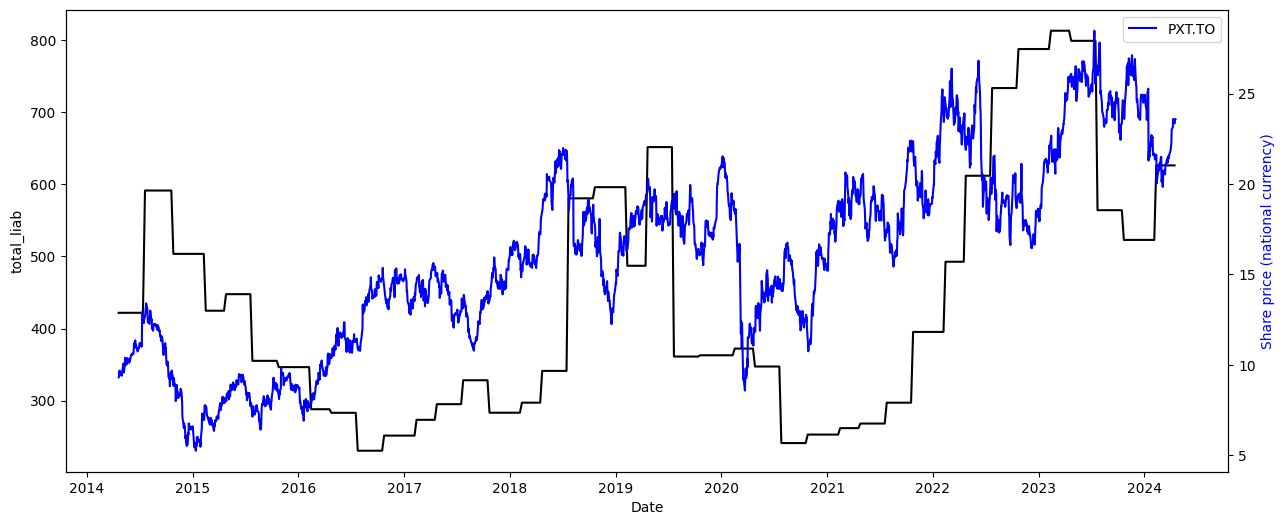

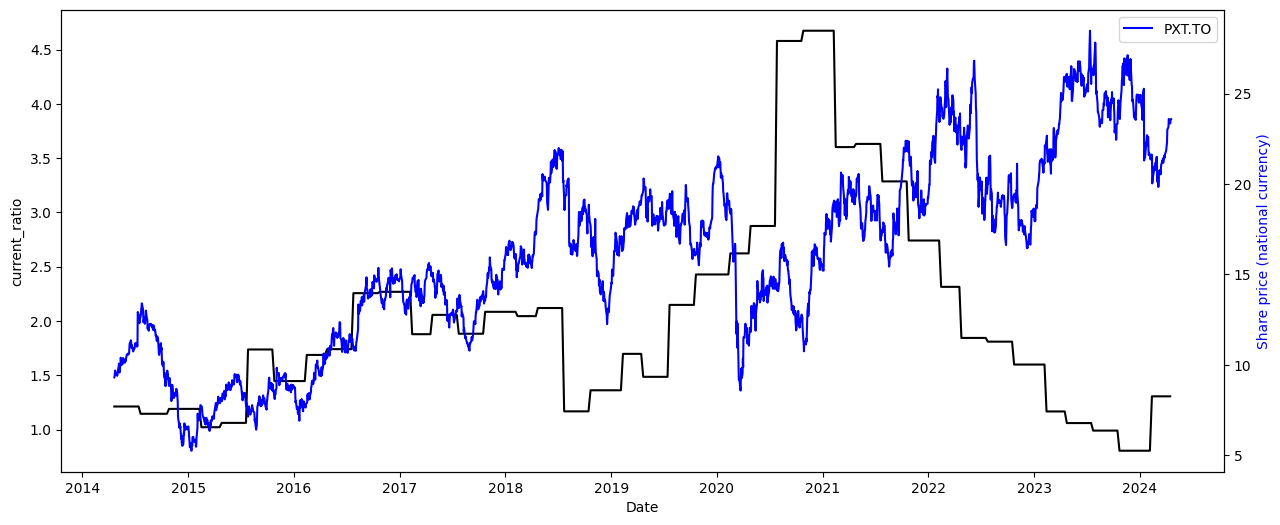

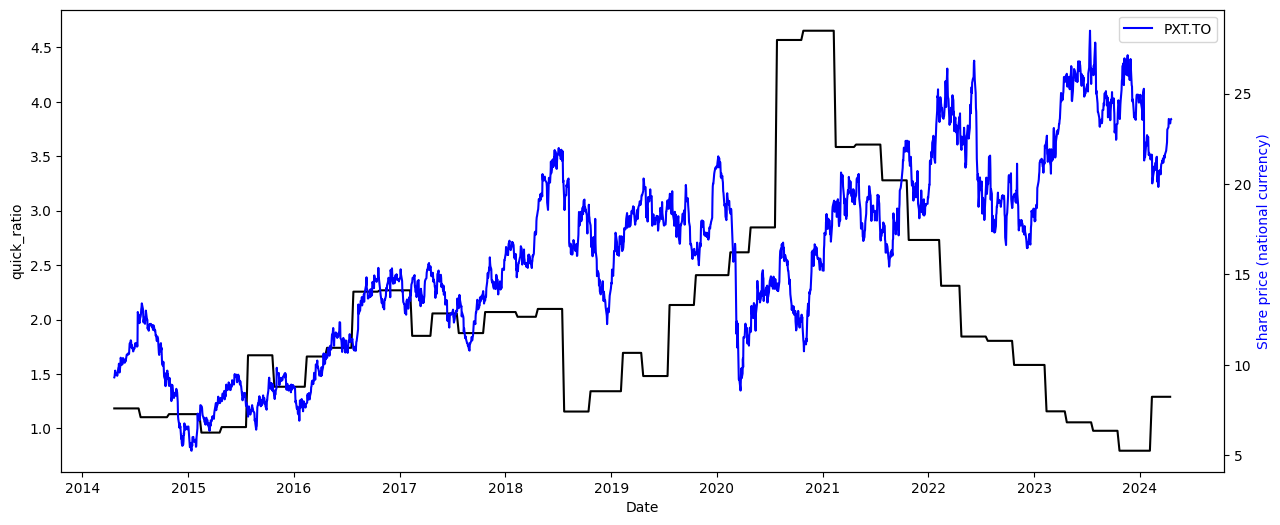

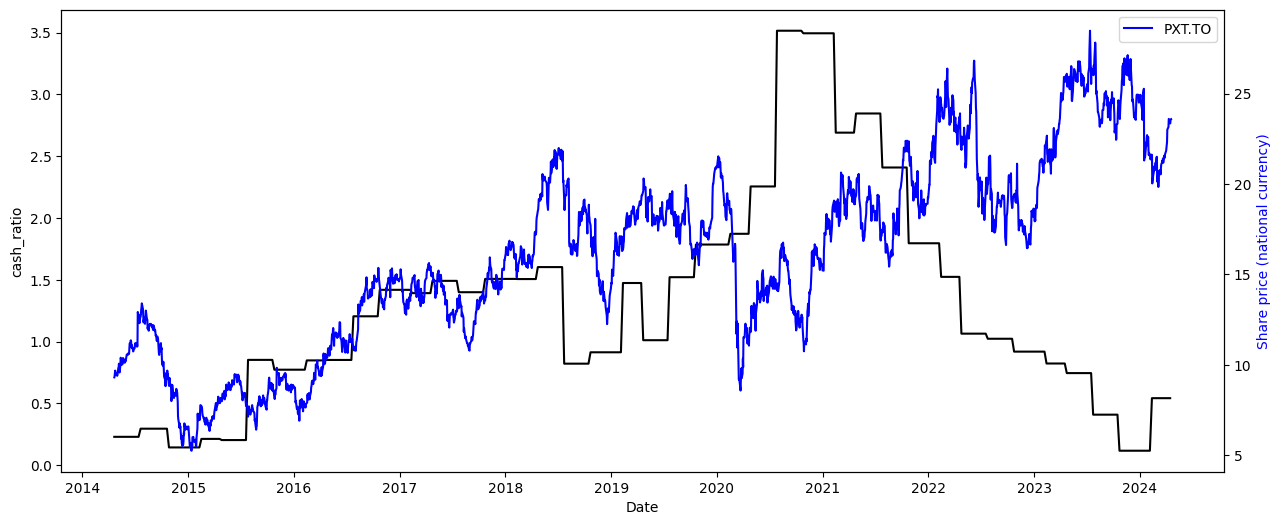

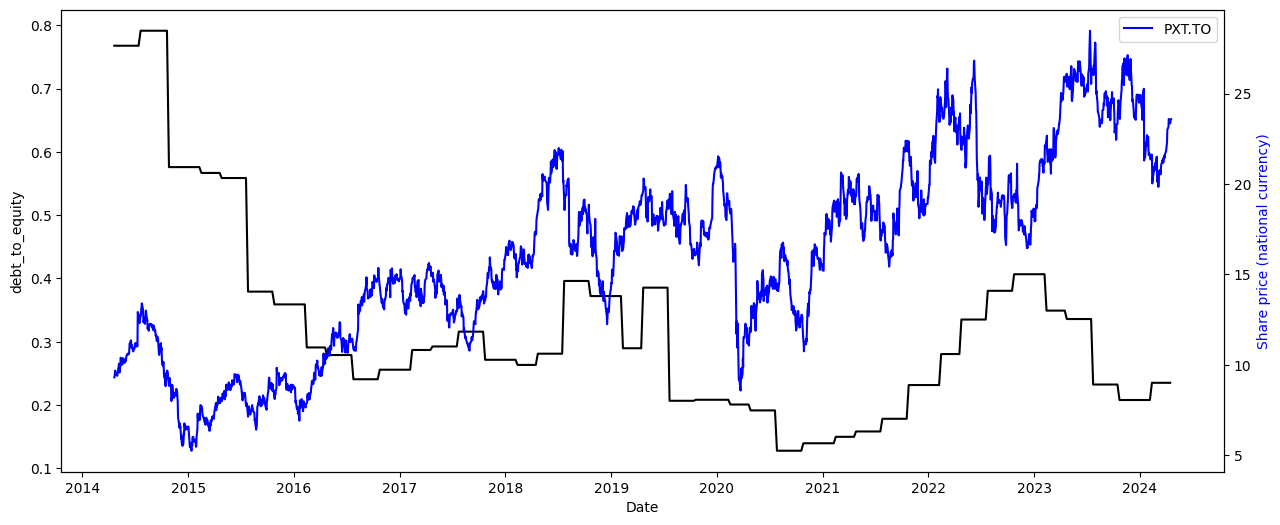

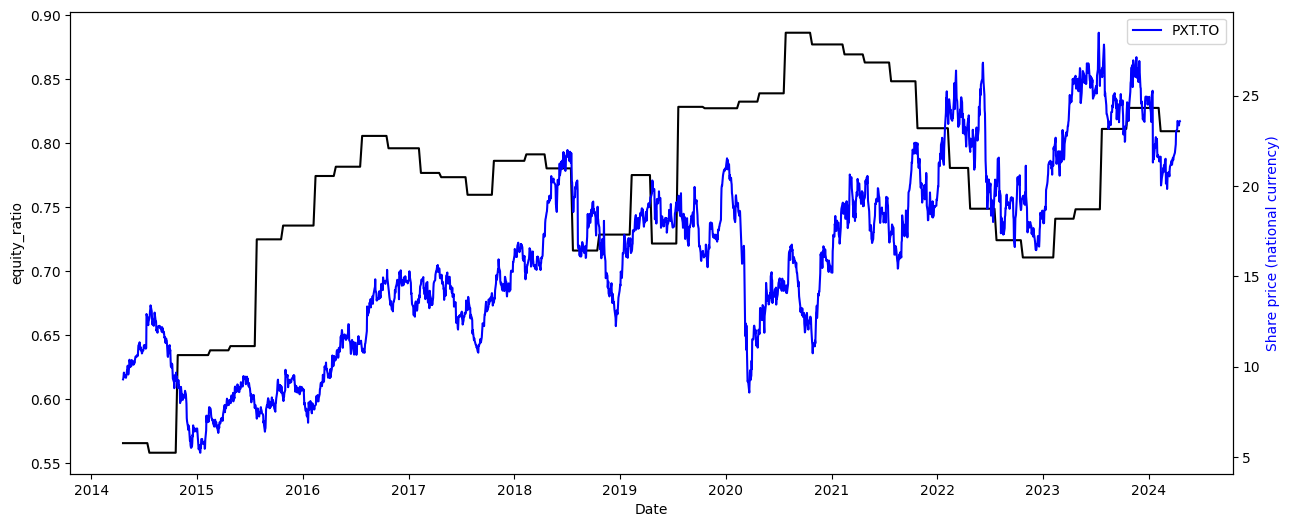

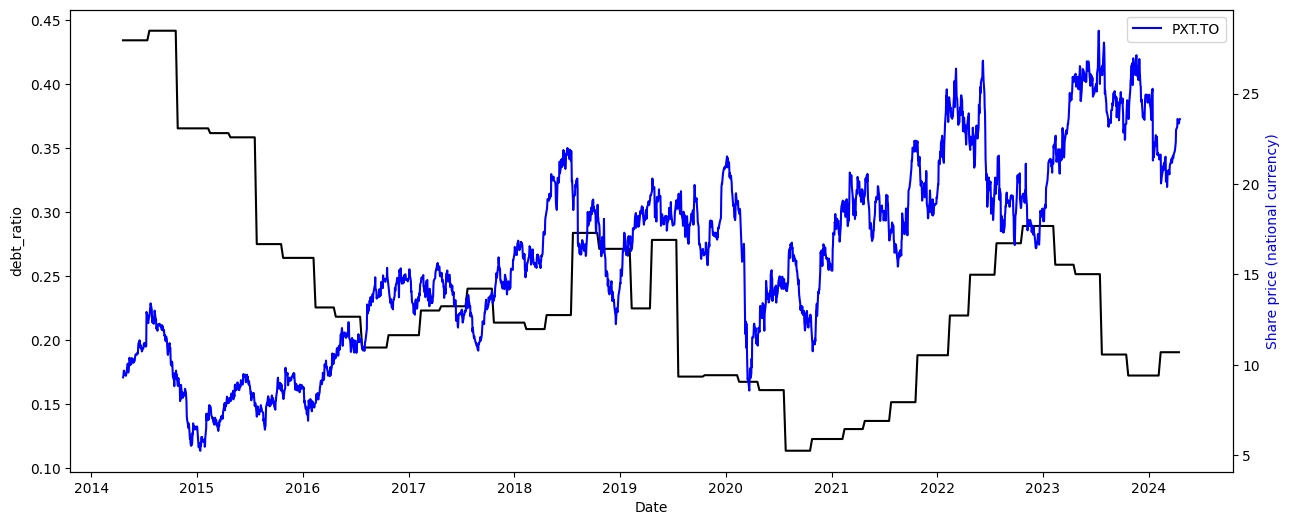

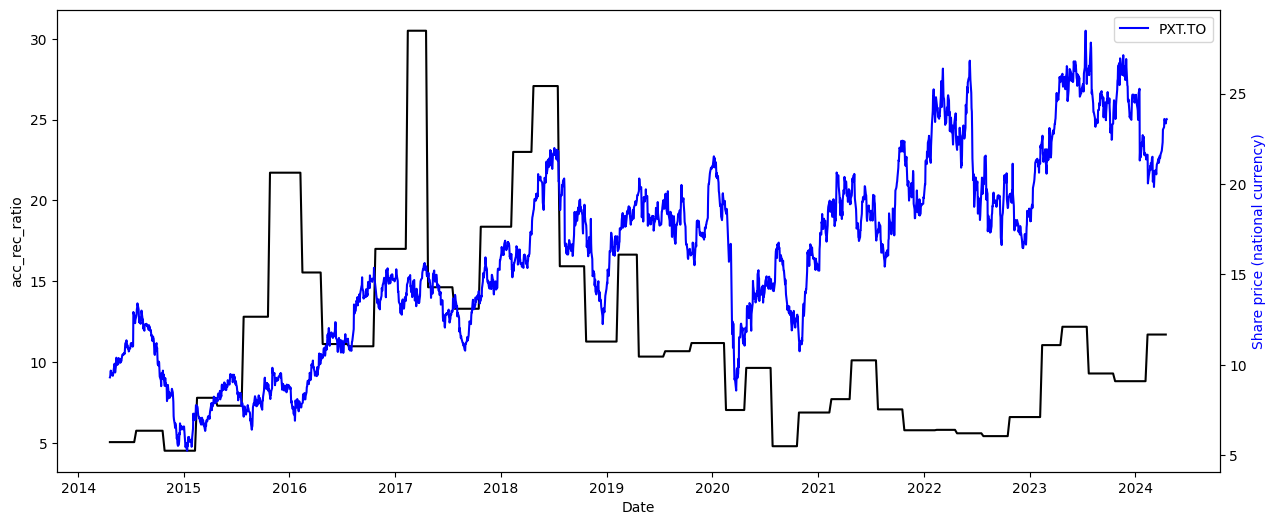

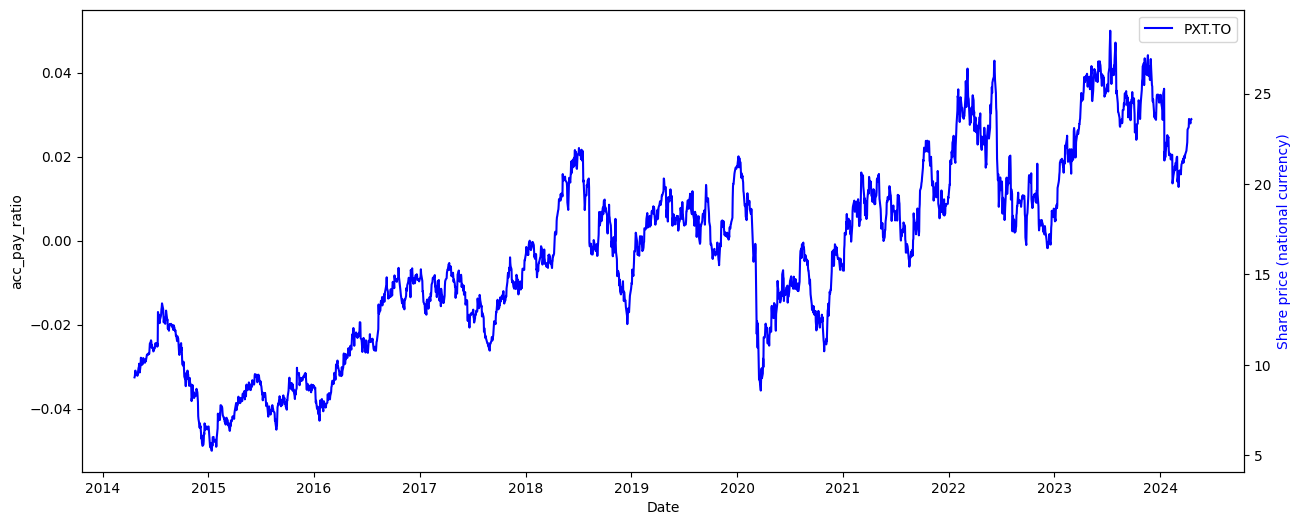

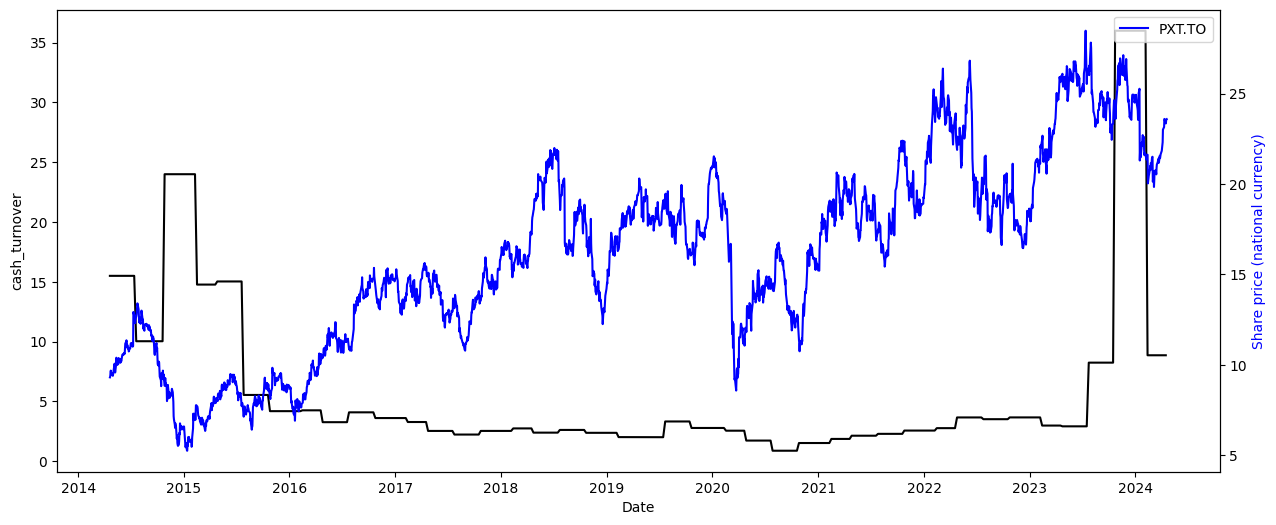

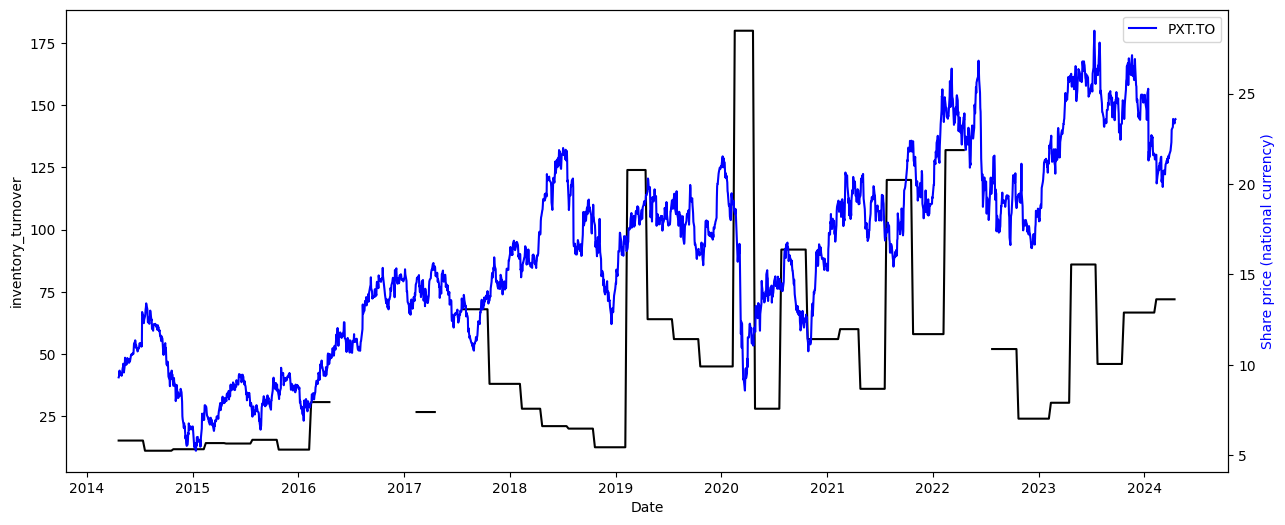

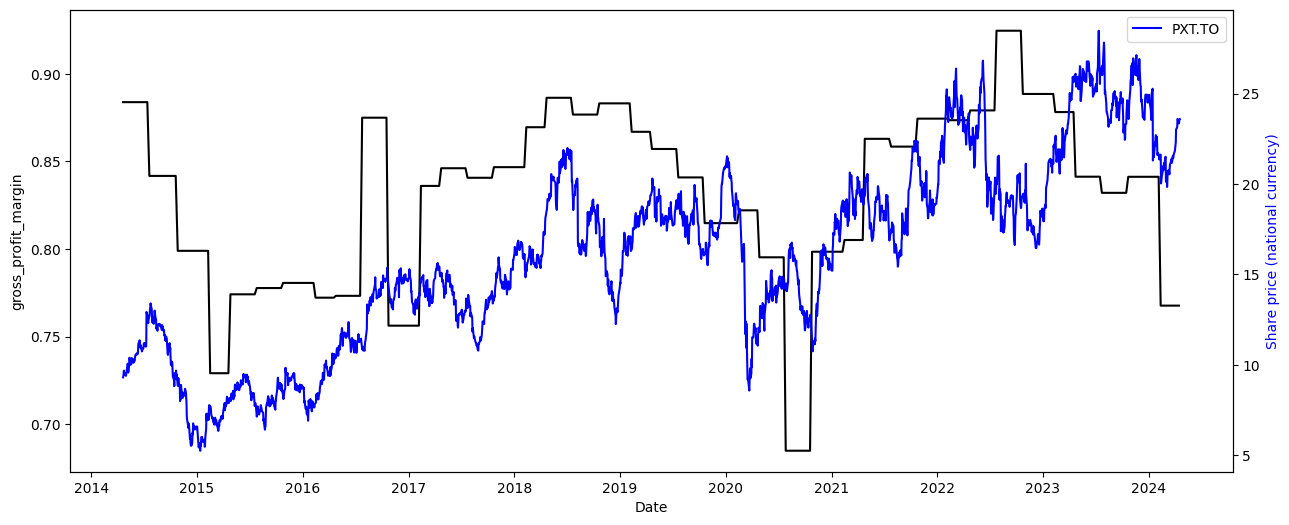

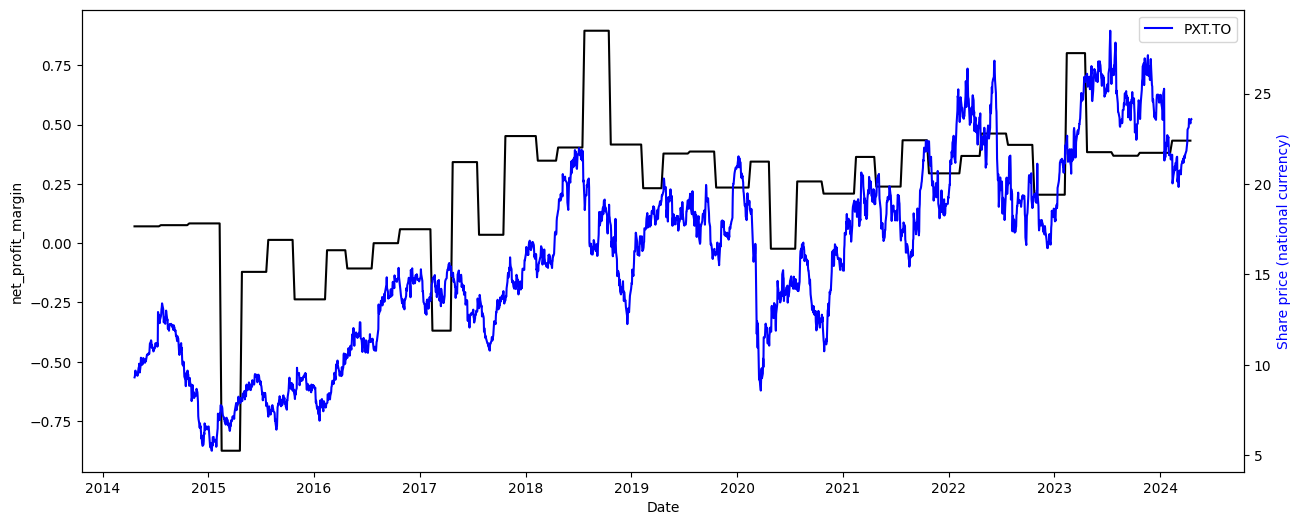

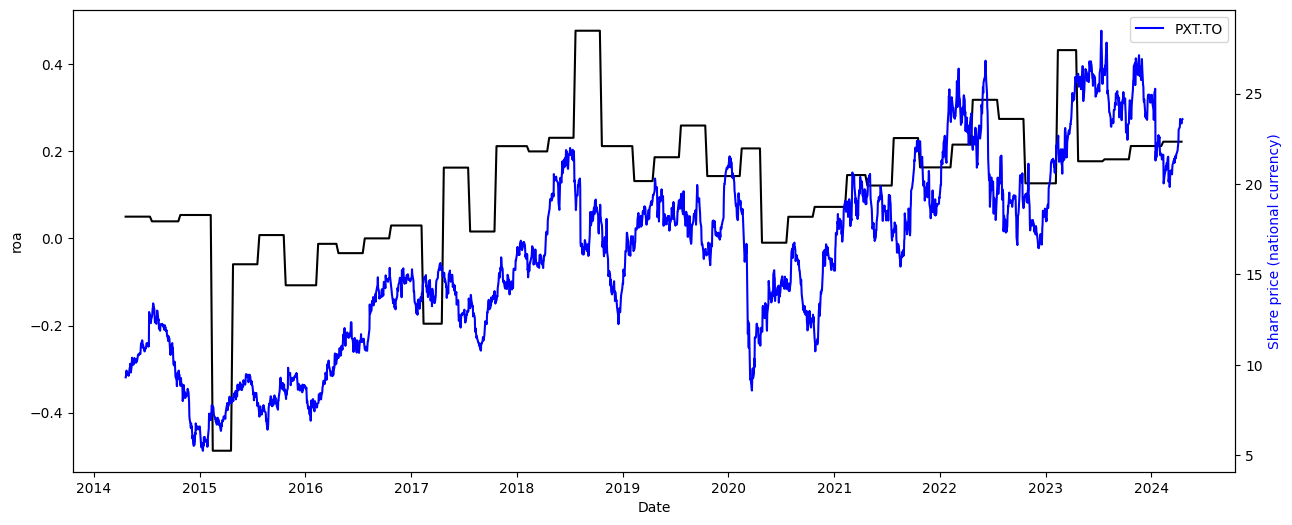

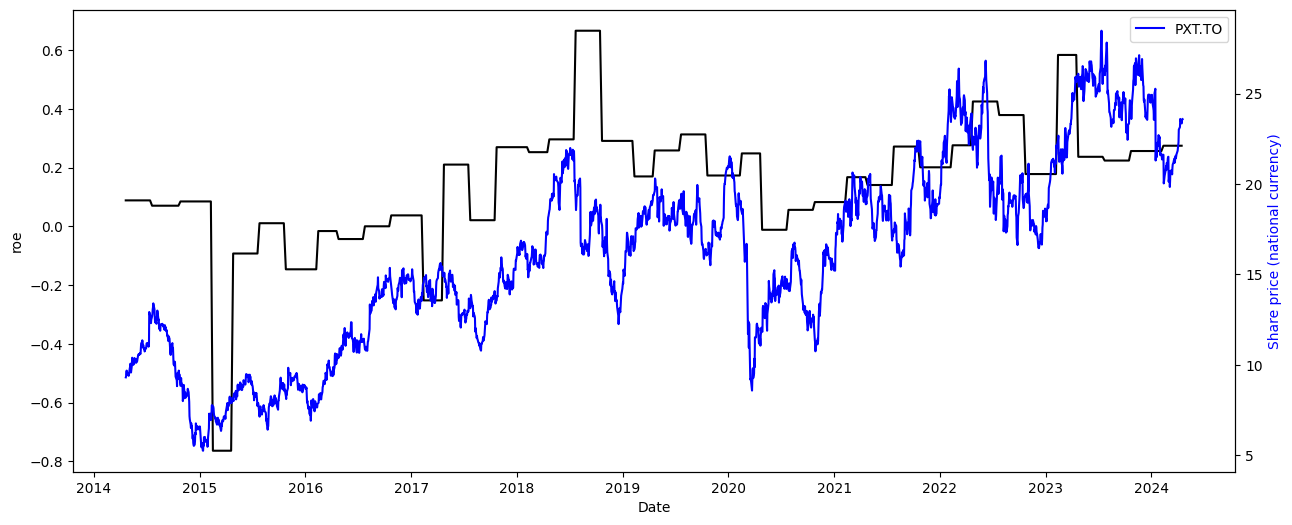

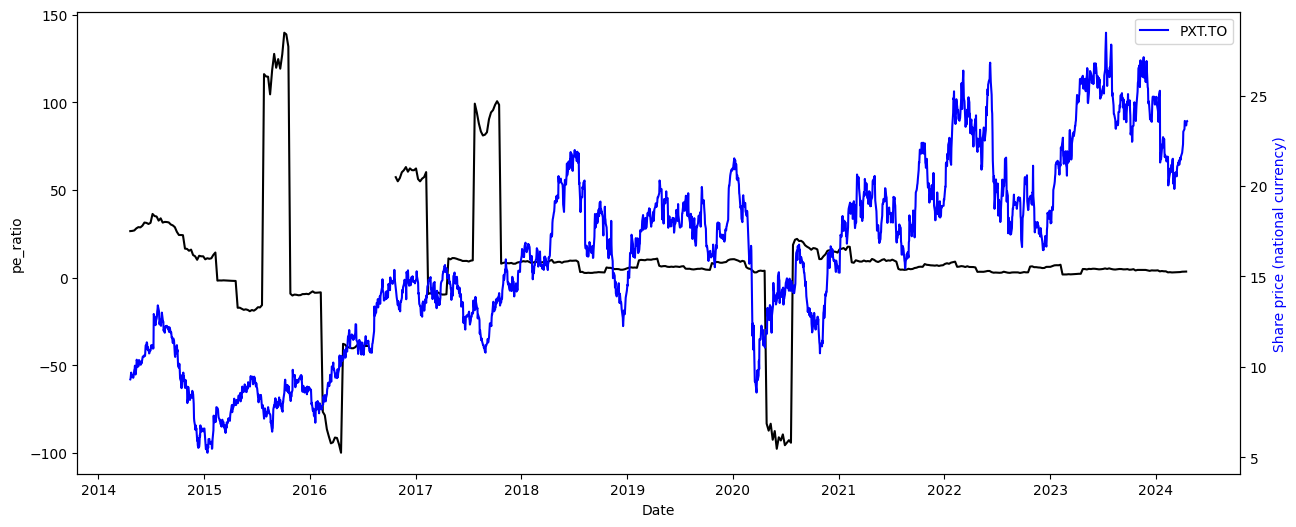

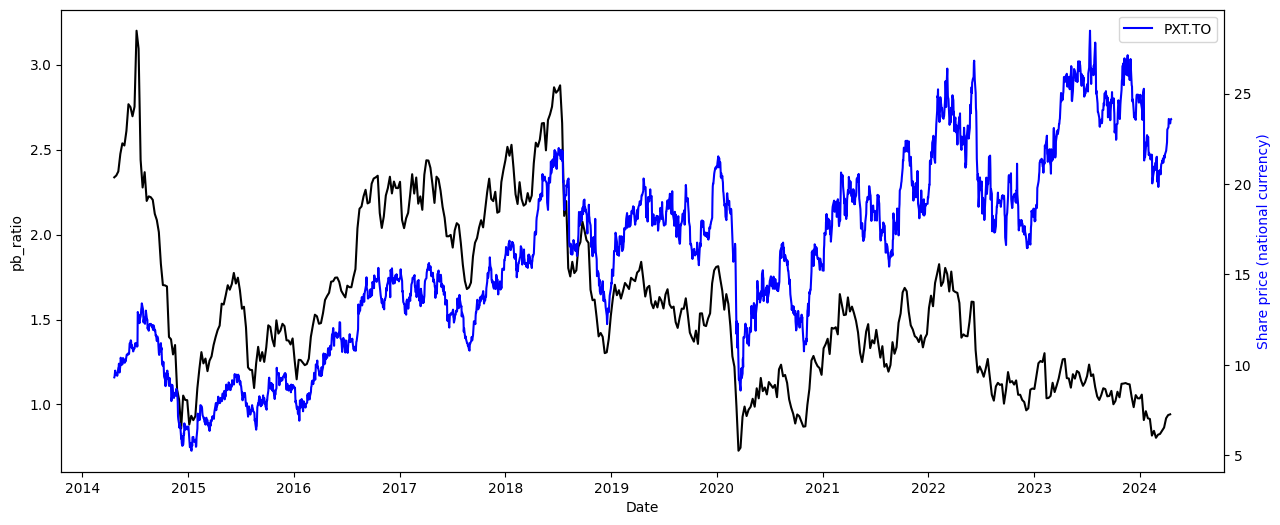

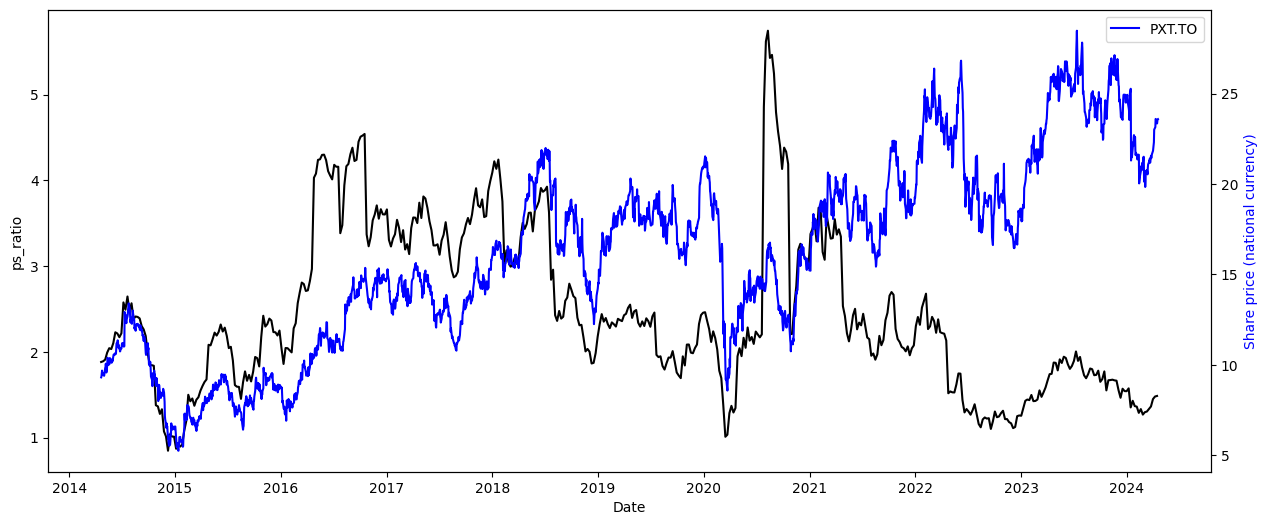

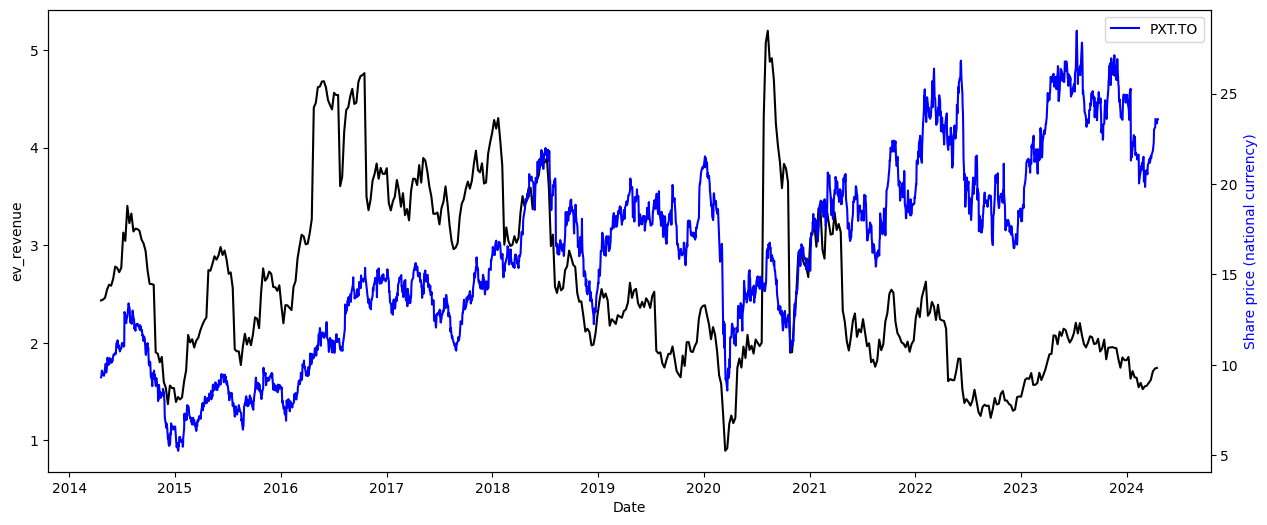

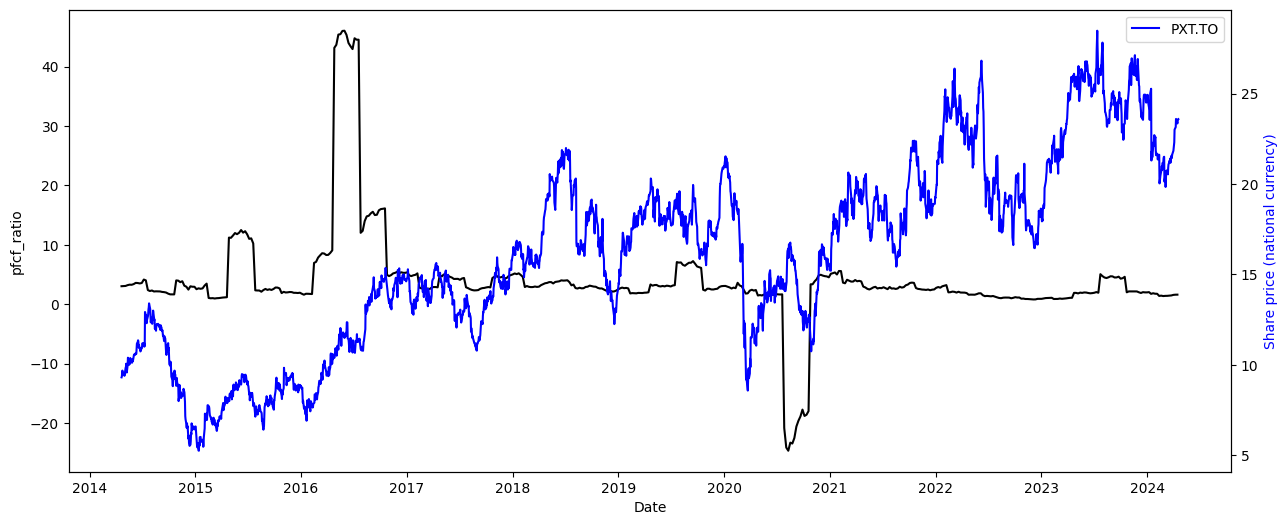

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

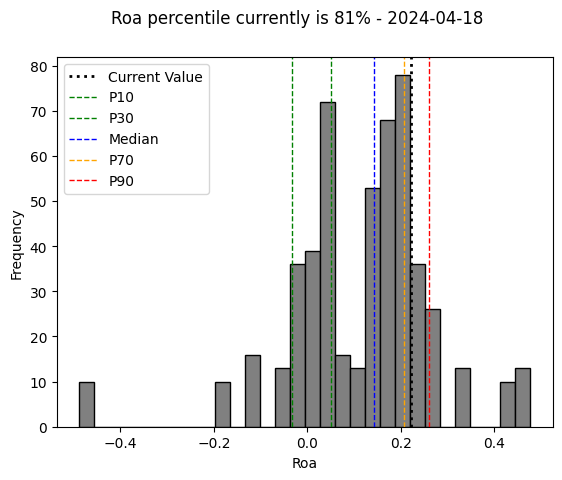

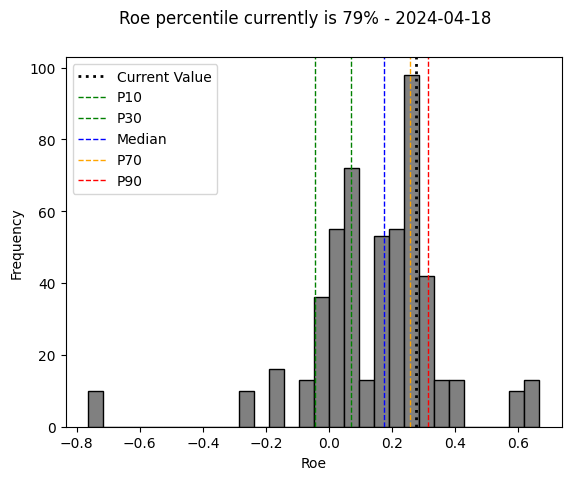

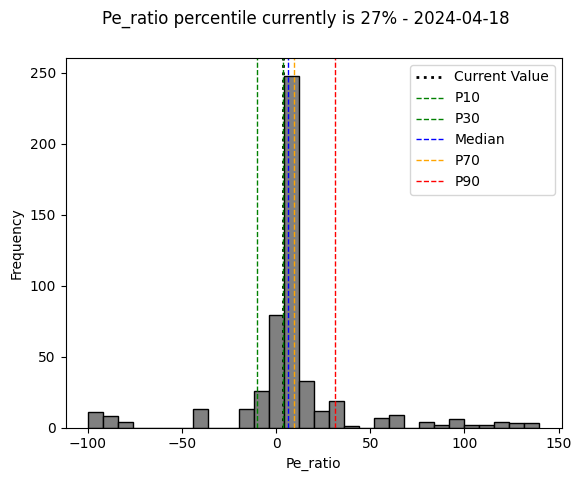

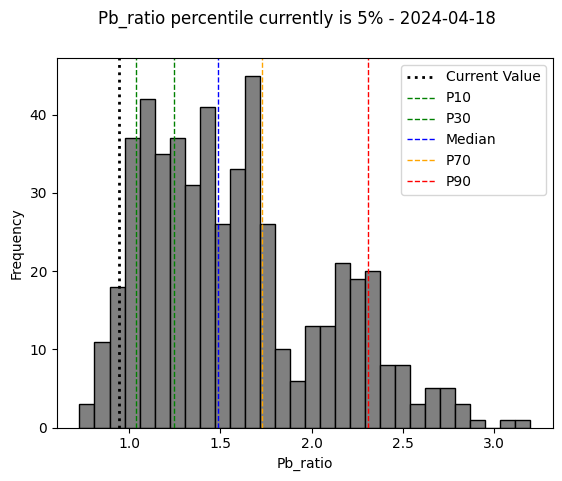

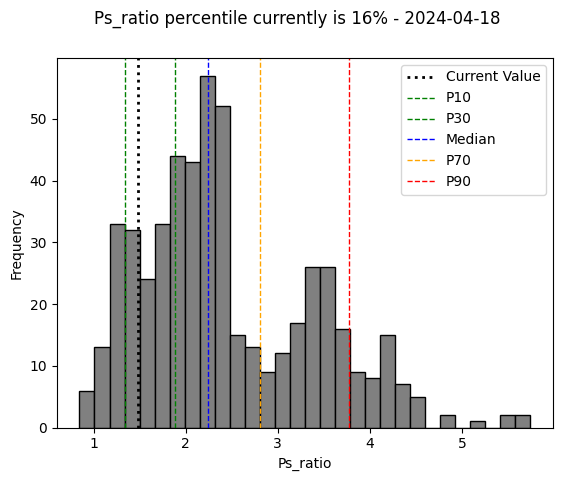

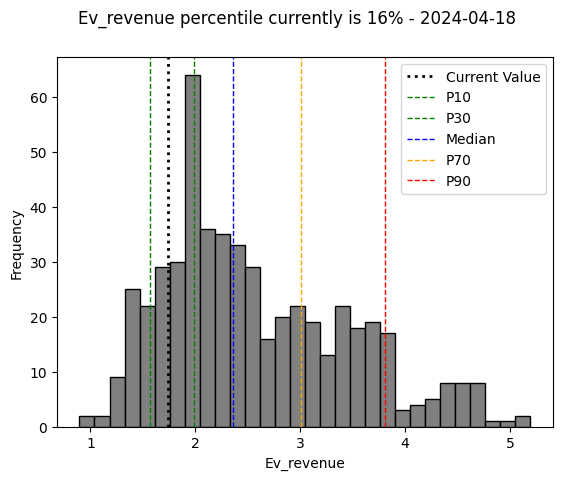

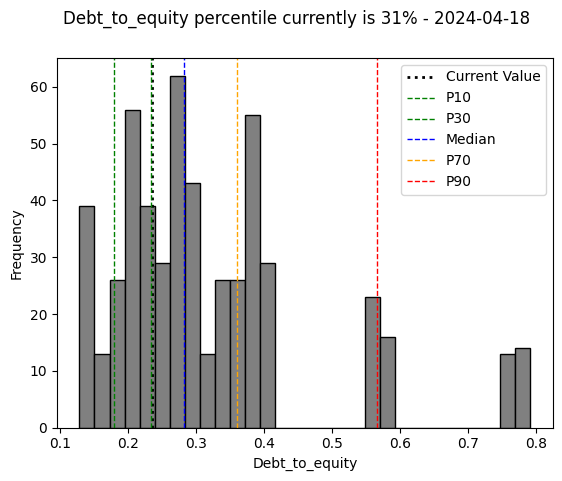

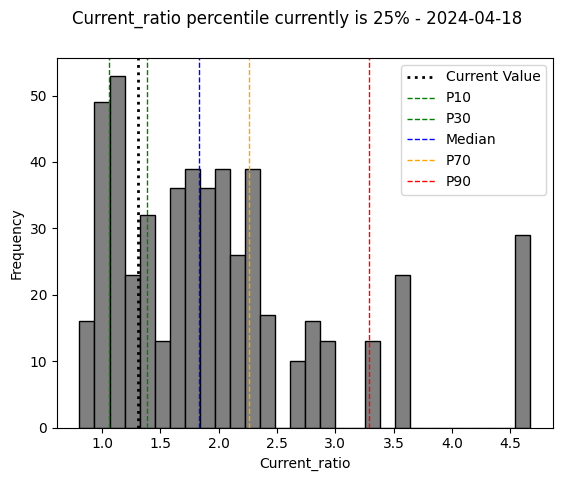

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.995715,0.041121,-0.053366,-0.159072,-0.269729,-0.242393,-0.004681
roe,0.995715,1.000000,0.045130,-0.030999,-0.147780,-0.249372,-0.202693,-0.024241
pe_ratio,0.041121,0.045130,1.000000,0.198729,0.039434,0.059750,0.145666,0.004063
pb_ratio,-0.053366,-0.030999,0.198729,1.000000,0.587344,0.667002,0.246652,-0.078435
ps_ratio,-0.159072,-0.147780,0.039434,0.587344,1.000000,0.959222,-0.329767,0.460197
ev_revenue,-0.269729,-0.249372,0.059750,0.667002,0.959222,1.000000,-0.102470,0.243677
debt_to_equity,-0.242393,-0.202693,0.145666,0.246652,-0.329767,-0.102470,1.000000,-0.624141
current_ratio,-0.004681,-0.024241,0.004063,-0.078435,0.460197,0.243677,-0.624141,1.000000


10 timestemos have been found!


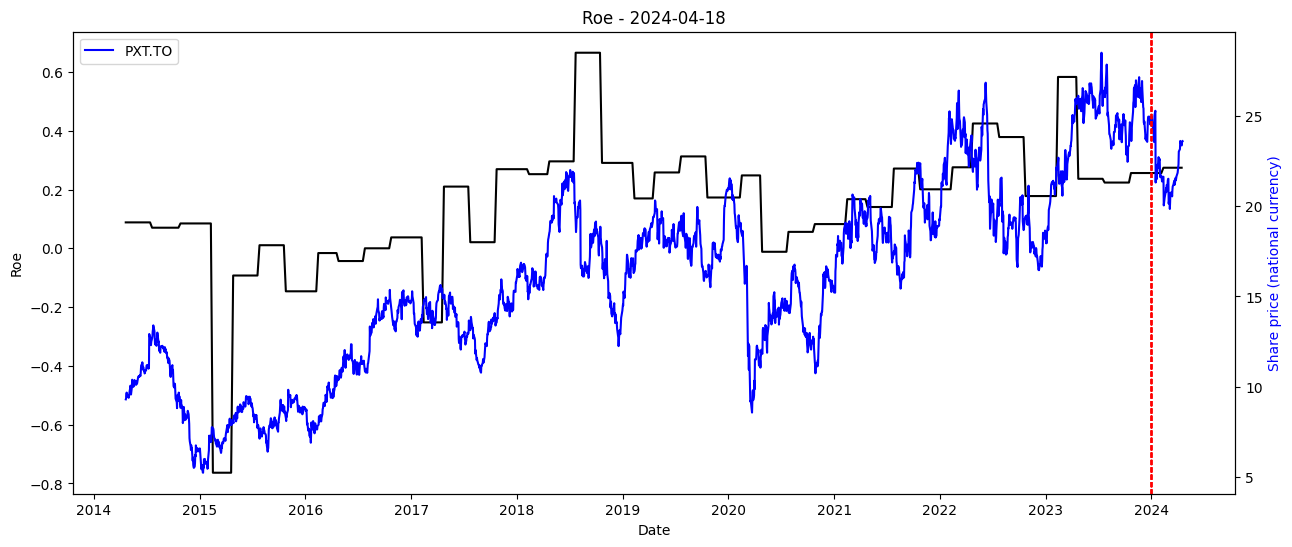

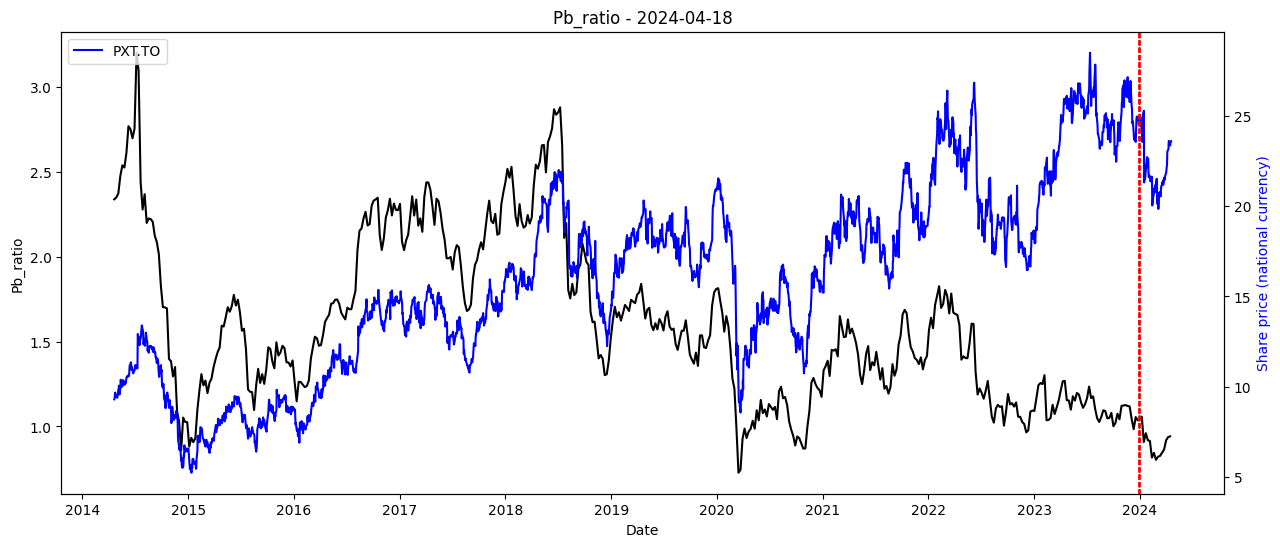

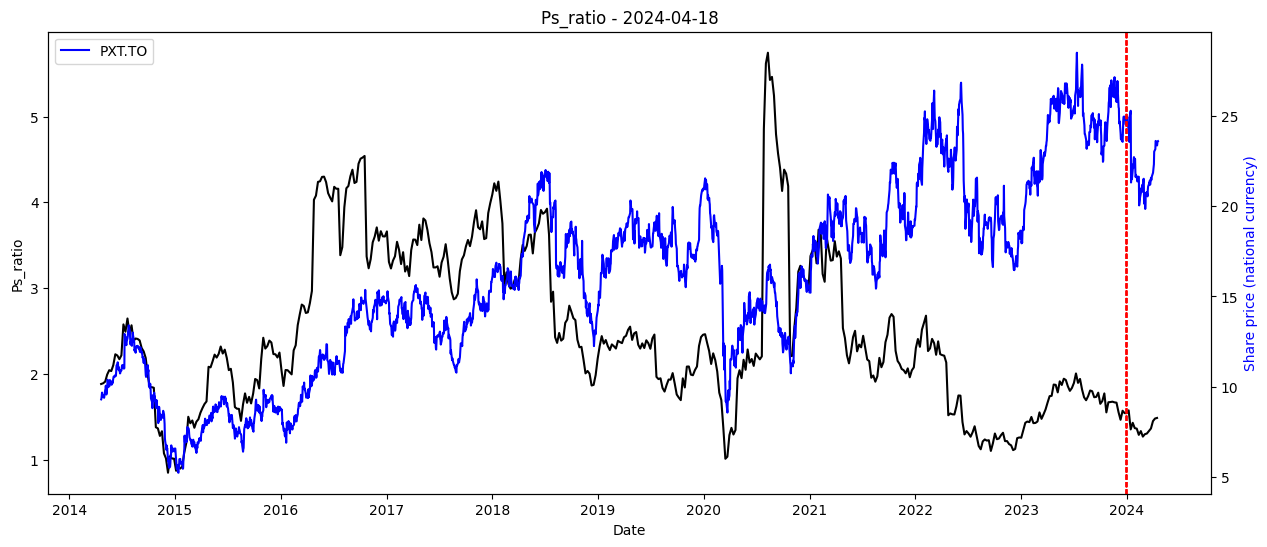

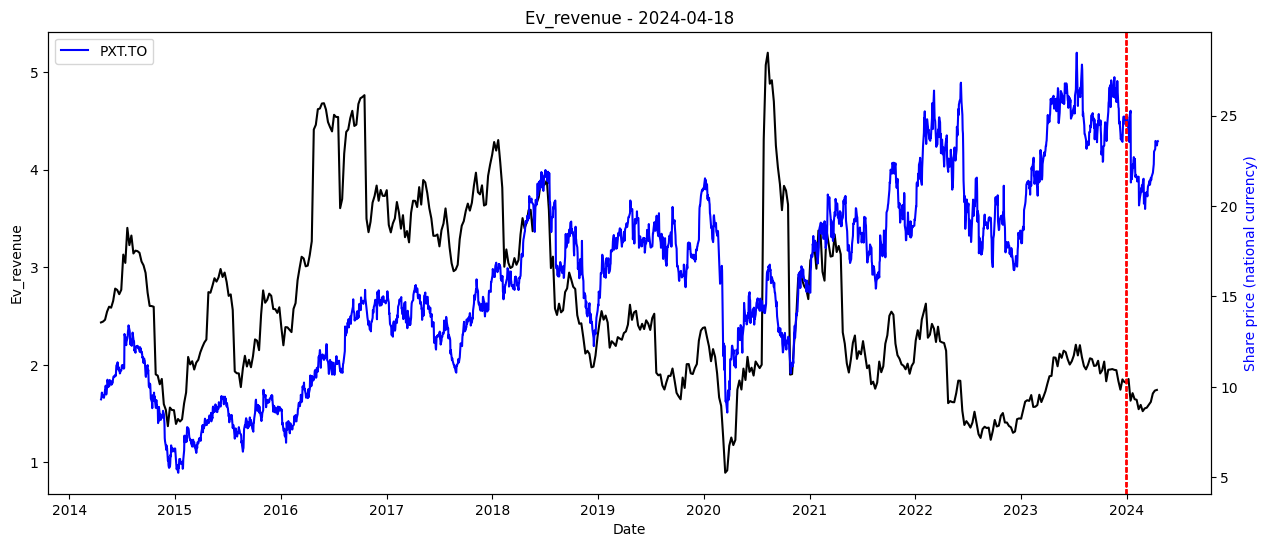

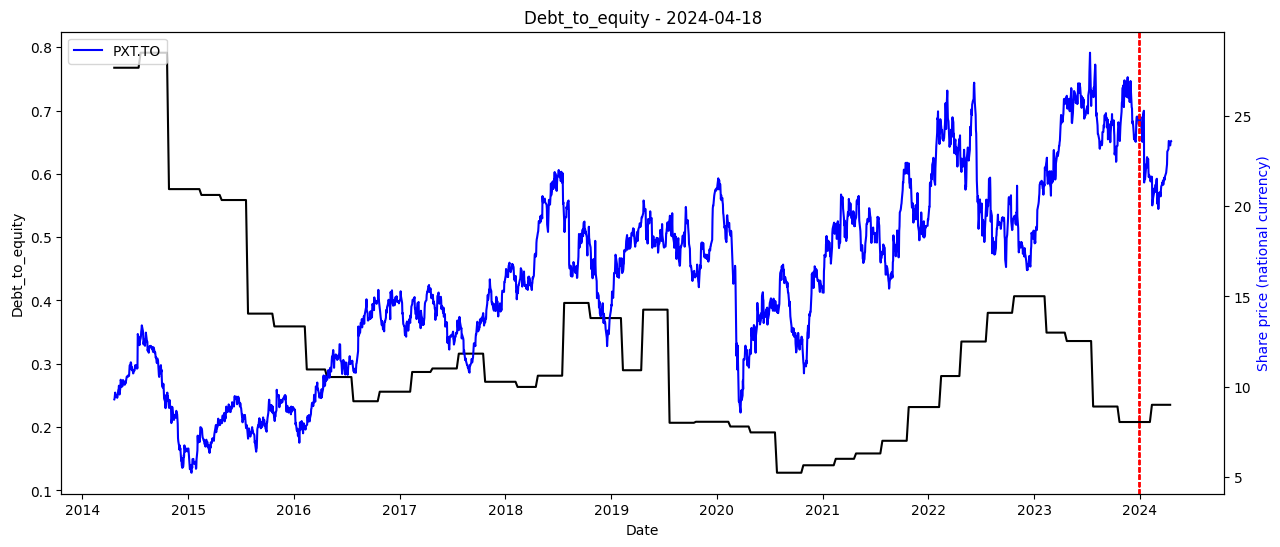

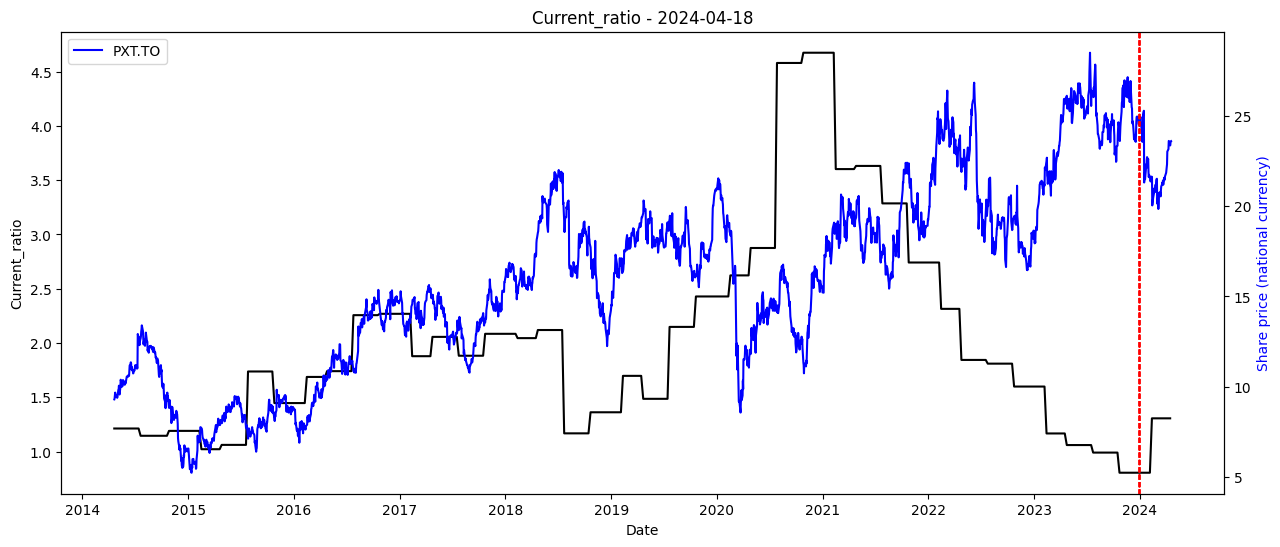

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )